<a href="https://colab.research.google.com/github/Diyon335/PRA3024/blob/master/Week4_Chris/final_LHCb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Make a new directory, and then download + unzip ROOT
!mkdir -p APPS
!cd APPS && wget https://root.cern.ch/download/root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz 
!cd APPS && tar -xf root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz

In [22]:
#Get some important files from ROOT
import sys
sys.path.append("/content/APPS/root/lib")
import ctypes
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libCore.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libThread.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libImt.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libRIO.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libNet.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libTree.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libMathMore.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libMathCore.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libMatrix.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libHist.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libGraf.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libGraf3d.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libMultiProc.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libMinuit.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libFoam.so')

<CDLL '/content/APPS/root/lib/libFoam.so', handle 56321b756300 at 7fc06b690250>

In [0]:
#Get our data from CERN
!mkdir -p DATA && cd DATA  && wget http://opendata.cern.ch/record/4900/files/B2HHH_MagnetUp.root

In [0]:
#Import the necessary libraries
import ROOT
import math

In [0]:
#Open the root file containing all our data, and get the tree of events
file = ROOT.TFile.Open("DATA/B2HHH_MagnetUp.root", "READONLY")
tree = file.Get("DecayTree")
tree.SetName("tree")
#shows any event
#tree.Show(0)

In [0]:
#These are constants or things you can tweak when you call your functions below
#Some you may not even use (for example bins and histRange) since you need to play around with them to get better curves and etc

speed_light = "1"
kaonMass = "493.677" #MeV/c**2

bins = "300"
histRange = ["0","300000"]

stats = ["B_VertexChi2","_ProbK","_ProbPi"]
directions = ["_PX","_PY","_PZ"]
daughters = ["H1","H2","H3"]

In [0]:
### All functions used ###

########    plots a histogram    ##########

#black - 1, red - 2, green - 3, blue - 4 (line colours)
#one drawback of histogram functions is that you cannot use operands in strings for ranges. for example 1E5, 1e5, 10**5, .. etc
def plotHist(fromTree,variable, histName, histTitle, bins, from_x, to_x, xTitle, yTitle="Number of Events",lineCol = 4):
  histogram = ROOT.TH1F(histName,histTitle,int(bins),int(from_x),int(to_x))
  fromTree.Draw(variable+">>"+histName+"(" +bins+","+from_x+","+to_x+")")
  histogram = ROOT.gDirectory.Get(histName)
  histogram.SetLineColor(lineCol)
  histogram.GetXaxis().SetTitle(xTitle)
  histogram.GetYaxis().SetTitle(yTitle)
  histogram.SetTitle(histTitle)
  histogram.Draw()
  return None


########     Plot multiple Hists   ########

#Make the names of histograms and histNames the same for easy book-keeping
def plotMulHists(histograms, fromTree, variables, histNames, histTitle, bins, from_x, to_x, xTitle, lineCols, yTitle="Number of Events", yMax = 250000):
  
  for a in range(len(histograms)):
    histograms[a] = ROOT.TH1F(histNames[a],histTitle,int(bins),int(from_x),int(to_x))

  for b in range(len(histNames)):
    fromTree[b].Draw(variables[b]+">>"+histNames[b]+"(" +bins+","+from_x+","+to_x+")")
  
  for c in range(len(histograms)):
    histograms[c] = ROOT.gDirectory.Get(histNames[c])

  for d in range(len(histograms)):
    histograms[d].SetLineColor(lineCols[d])
  
  histograms[0].GetXaxis().SetTitle(xTitle)
  histograms[0].GetYaxis().SetTitle(yTitle)
  histograms[0].SetTitle(histTitle)
  histograms[0].Draw()
  histograms[0].SetMaximum(yMax)

  legend = ROOT.TLegend(0.7 ,0.6 ,0.85 ,0.75)
  ROOT.SetOwnership(legend, False)
  legend.SetBorderSize(1)
  legend.SetShadowColor(2)
  for l in range(len(histograms)):
    legend.AddEntry(histograms[l],histNames[l],"l")
  legend.SetTextSize(0.04)
  legend.SetTextColor(1)
  legend.Draw("same")

  for i in range(len(histograms)):
    if i != 0:
      histograms[i].Draw("same")

  return None


########      Magnitude of momentum       ########
def magnOfMomentum(daughter):
  return "sqrt({}_PX**2 + {}_PY**2 + {}_PZ**2)".format(daughter,daughter,daughter)

########   Totel momentum in a direction  ########
def totalMomentumIn(direction):
  return "(H1{}+H2{}+H3{})".format(direction,direction,direction)

########        Calculates energy         ######### 
def energyOf(daughter, mass):
  return "sqrt(({})**2 + ({})**2)".format(magnOfMomentum(daughter),mass)

####### This function is used to fit data ########

#The function by default fits the graph with a gaussian. whether you want expo or cb, is up to you
#If you want to add more shapes, you must add their respective parameters and then code inside this function accordingly
#normalised graphs are defaults and must be changed here
def fitData(resultArray,histogram, fromTree, variable, variableName, variableUnit, variableParams,GaussParams, ExpoParams,cbParams, Expo = False,CB = False):

  variable = ROOT.RooRealVar(variableName, variableName, variableParams[0], variableParams[1], variableUnit)
  gaussMean=ROOT.RooRealVar("gaussMean","gaussMean",GaussParams[0],GaussParams[1],GaussParams[2])
  gaussWidth=ROOT.RooRealVar("gaussWidth","gaussWidth",GaussParams[3],GaussParams[4],GaussParams[5])
  Gauss=ROOT.RooGaussian("Gauss","Gauss",variable,gaussMean,gaussWidth)
  gaussNorm  = ROOT.RooRealVar("gaussNorm","gaussNorm", fromTree.GetEntries()/500 * 2, 0.5, fromTree.GetEntries() * 2)

  argList = ROOT.RooArgList(Gauss)
  normArgList = ROOT.RooArgList(gaussNorm)
  components = ["Gauss"]
  colors = [8,46,2]

  if(Expo==True):
    exponent=ROOT.RooRealVar("exponent", "exponent", ExpoParams[0], ExpoParams[1], ExpoParams[2])
    background=ROOT.RooExponential("background","background",variable,exponent)
    exponentialNorm  = ROOT.RooRealVar("exponentialNorm","exponentialNorm", fromTree.GetEntries()/200 * 3, 0, fromTree.GetEntries() * 2)

    argList.add(background)
    normArgList.add(exponentialNorm)
    components.append("background")
  if(CB==True):
    cb_width    = ROOT.RooRealVar("cb_width","cb_width",cbParams[0],cbParams[1],cbParams[2])
    cb_alpha    = ROOT.RooRealVar("cb_alpha","cb_alpha",ExpoParams[0],ExpoParams[1],ExpoParams[2])
    cb_n        = ROOT.RooRealVar("cb_n","cb_n",1.0,0.0,15.0)
    CB          = ROOT.RooCBShape("CB","CB", variable, gaussMean, cb_width, cb_alpha, cb_n)
    cb_Norm     = ROOT.RooRealVar("cb_Norm","cb_Norm", fromTree.GetEntries()/200 * 3, 0, fromTree.GetEntries() * 2)

    argList.add(CB)
    normArgList.add(cb_Norm)
    components.append("CB")
  
  model = ROOT.RooAddPdf("model","model",argList,normArgList)
  RootHistogram = ROOT.RooDataHist("RootHist","RootHist", ROOT.RooArgList(variable), histogram)
  model.fitTo(RootHistogram)
  frame=variable.frame()
  RootHistogram.plotOn(frame)

  for i in range(len(components)):
    model.plotOn(frame, ROOT.RooFit.Components(components[i]),ROOT.RooFit.LineColor(colors[i]),ROOT.RooFit.LineStyle(2))
  
  model.plotOn(frame)
  frame.Draw()
  Yield = 0
  Error = 0

  for pdf in range(len(normArgList)):
    Yield += normArgList[pdf].getValV()
    Error += normArgList[pdf].getError()

  print("Yield: {} +/ {} || Chi2: {}".format(Yield , Error , frame.chiSquare()))
  resultArray.append(Yield)
  resultArray.append(Error)
  resultArray.append(frame.chiSquare())
  return None

    

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


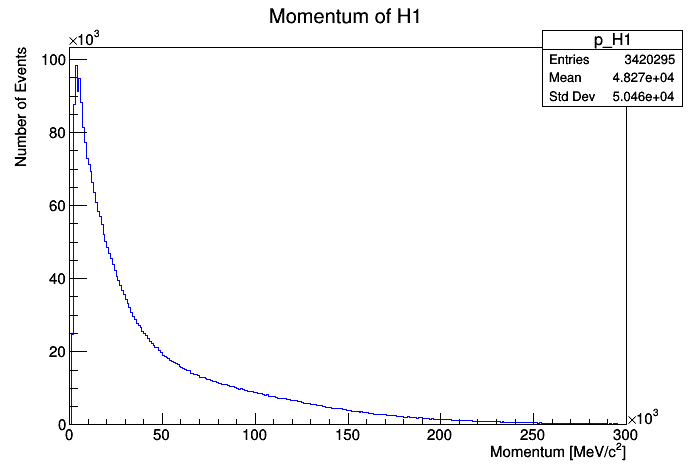

In [53]:
#Plotting the momentum of H1
canvas = ROOT.TCanvas("canvas")
plotHist(tree, magnOfMomentum(daughters[0]),"p_{}".format(daughters[0]), "Momentum of {}".format(daughters[0]), bins, histRange[0],histRange[1], "Momentum [MeV/c^{2}]")
canvas.Update()
canvas.Draw()

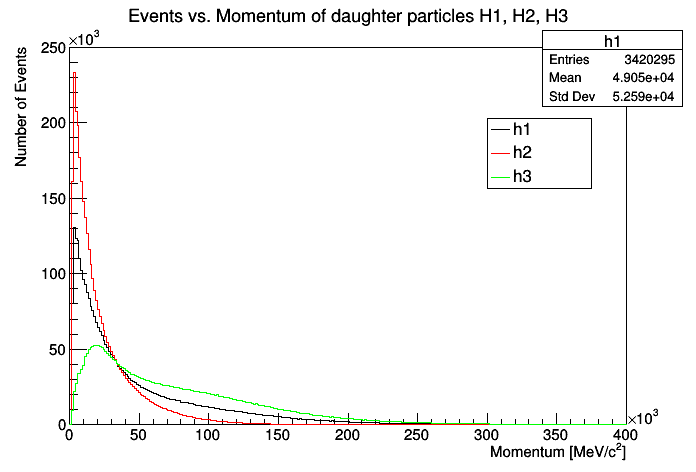

In [54]:
#Plotting all momentums 
histograms = ["h1","h2","h3"]
histNames = ["h1","h2","h3"]
variables = [magnOfMomentum(daughters[0]) , magnOfMomentum(daughters[1]), magnOfMomentum(daughters[2])]
histTitle = "Events vs. Momentum of daughter particles H1, H2, H3"
lineCols = [1,2,3]
trees = [tree,tree,tree]

plotMulHists(histograms, trees,variables,histNames,histTitle,bins,"0","400000","Momentum [MeV/c^{2}]",lineCols)
canvas.Update()
canvas.Draw()

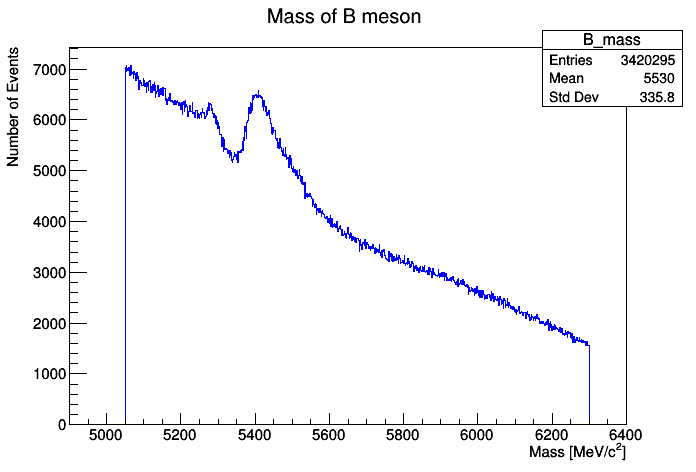

In [55]:
#To get the energy of the B meson, we use the conservation of energy
#Energy of B = energy of daughters
#B --> K K K
B_energy = "{} + {} + {}".format(energyOf(daughters[0],kaonMass) , energyOf(daughters[1],kaonMass) , energyOf(daughters[2],kaonMass))
#The momentum of B is the magnitude of the total momentum in the x, y and z direction
B_momentum = "sqrt({}**2 + {}**2 + {}**2)".format(totalMomentumIn(directions[0]) , totalMomentumIn(directions[1]) , totalMomentumIn(directions[2]))
#B mass can be found by rearranging the equation
#We've set c = 1
B_mass = "sqrt( ({})**2 - ({})**2)".format(B_energy, B_momentum)

plotHist(tree,B_mass,"B_mass","Mass of B meson","1000","4900","6400","Mass [MeV/c^{2}]")
canvas.Update()
canvas.Draw()

The mean mass is 5530 MeV/c^2 , which is quite close to the expected value of 5279.29 MeV/c^2. Now cuts will be applied for better data 

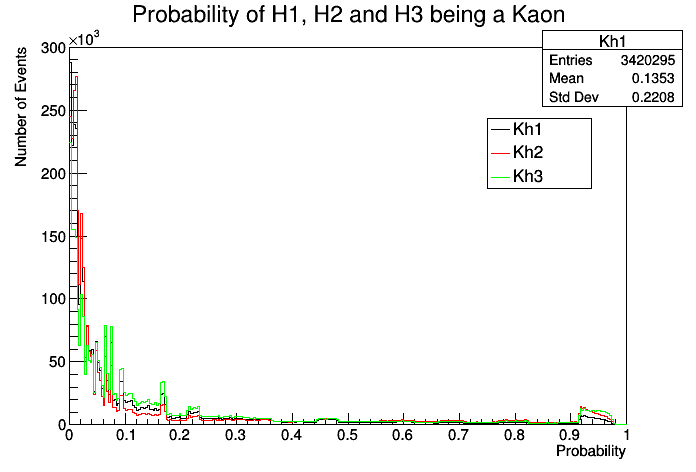

In [56]:
#To determine cuts, we need to see the probabilities of what the daughters were
#Checking the probability of them being a Kaon
probK_histograms = ["Kh1","Kh2","Kh3"]
probK_histNames = ["Kh1","Kh2","Kh3"]
probK_variables = [daughters[0]+stats[1], daughters[1]+stats[1], daughters[2]+stats[1]]
histTitle = "Probability of H1, H2 and H3 being a Kaon"
lineCols = [1,2,3]
trees = [tree,tree,tree]

plotMulHists(probK_histograms, trees,probK_variables,probK_histNames,histTitle,bins,"0","1","Probability",lineCols,yTitle = "Number of Events", yMax=300000)
canvas.Update()
canvas.Draw()

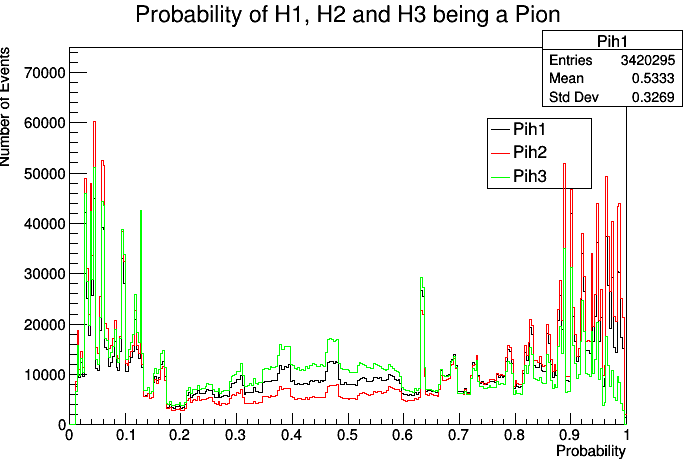

In [57]:
#Checking the probability of them being a Muon
probPi_histograms = ["Pih1","Pih2","Pih3"]
probPi_histNames = ["Pih1","Pih2","Pih3"]
probPi_variables = [daughters[0]+stats[2], daughters[1]+stats[2], daughters[2]+stats[2]]
histTitle = "Probability of H1, H2 and H3 being a Pion"
lineCols = [1,2,3]
trees = [tree,tree,tree]

plotMulHists(probPi_histograms, trees,probPi_variables,probPi_histNames,histTitle,bins,"0","1","Probability",lineCols,yTitle = "Number of Events", yMax=75000)
canvas.Update()
canvas.Draw()

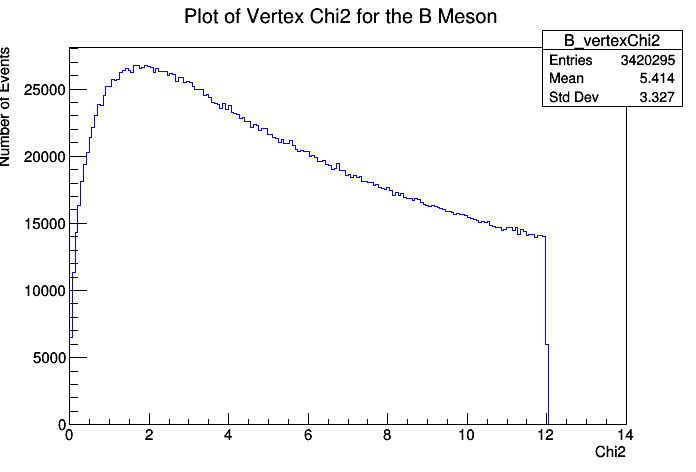

In [58]:
#Checking how accurate the tracing of trajectories were
plotHist(tree,stats[0],"B_vertexChi2","Plot of Vertex Chi2 for the B Meson","200","0","14","Chi2")
canvas.Update()
canvas.Draw()

In [0]:
#Here I make a cut and apply it to the tree
cut = ("!H1_isMuon & !H2_isMuon & !H3_isMuon & H1_ProbPi < 0.15 & H2_ProbPi < 0.15 & H3_ProbPi < 0.15 & H1_ProbK > 0.5 & H2_ProbK > 0.5 & H3_ProbK > 0.5 & B_VertexChi2 < 6")
cutTree = tree.CopyTree(cut)

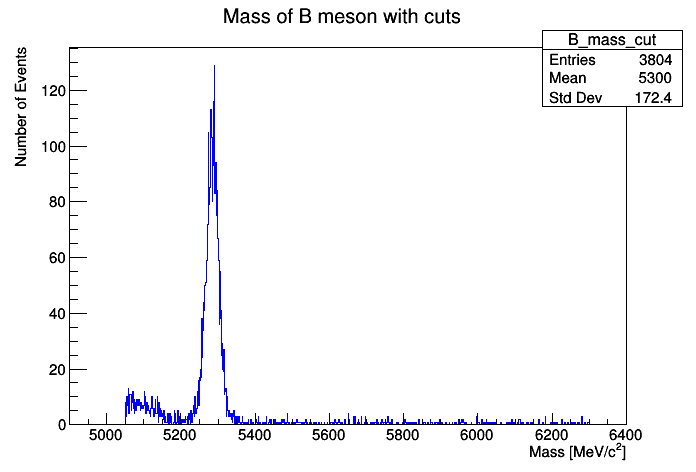

In [60]:
#How does the cut affect our mass?
plotHist(cutTree,B_mass,"B_mass_cut","Mass of B meson with cuts","1000","4900","6400","Mass [MeV/c^{2}]")
canvas.Update()
canvas.Draw()

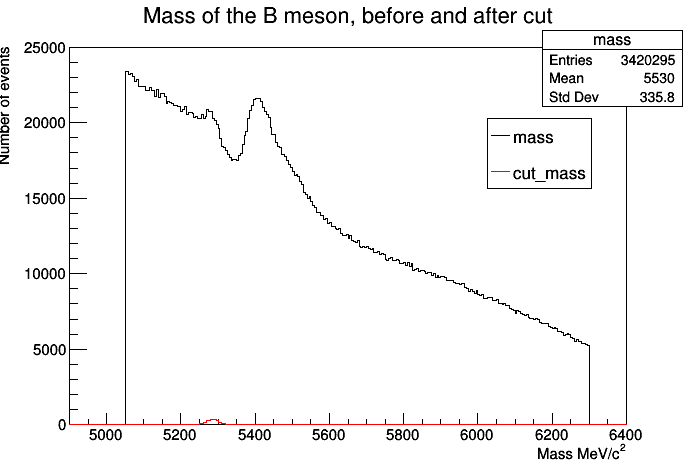

In [61]:
#Comparing the masses before and after the cut
histograms = ["mass","cut_mass"]
histNames = ["mass","cut_mass"]
variables = [B_mass,B_mass]
histTitle = "Mass of the B meson, before and after cut"
lineCols = [1,2]
trees = [tree,cutTree]

plotMulHists(histograms, trees,variables,histNames,histTitle,bins,"4900","6400","Mass MeV/c^{2}",lineCols,yTitle="Number of events",yMax=25000)
canvas.Update()
canvas.Draw()

In [0]:
#Fitting the data
fromTree = cutTree
variable = B_mass
variableName = "B_mass"
variableUnit = "MeV/c^{2}"
#Variable Params must always follow [lower range, upper range]
variableParams = [5000,5500]
#Gauss Params must always follow [gaussmean, lower mean range, upper mean range, gauss width, upper width range, lower width range]
GaussParams = [5285, 5100, 5400, 15, 10, 20]
#expo params must always follow [exponent, lower range, upper range]
ExpoParams = [0.1,-1,1]
cbWidthParams = [15,10,20]
#This array is just to hold the results of our fit
resultArray = []

#The function requires a histogram to be initialised first
histo = ROOT.TH1F("histo","histogram for fitting",200,5000,6000)
cutTree.Draw(variable+">>histo(200,5000,6000)")
histo = ROOT.gDirectory.Get("histo")
histo.SetTitle("Fitted Data")
histo.GetXaxis().SetTitle("Mass MeV/c^{2}")
histo.GetYaxis().SetTitle("Events")
histo.Draw()
#change which shapes you want accordingly
fitData(resultArray,histo,fromTree,variable,variableName,variableUnit,variableParams,GaussParams,ExpoParams,cbWidthParams,Expo=True,CB=False)
canvas.Update()
canvas.Draw()

Yield: 3555.95512159 +/- 85.563813386

Chi2: 1.91724762794


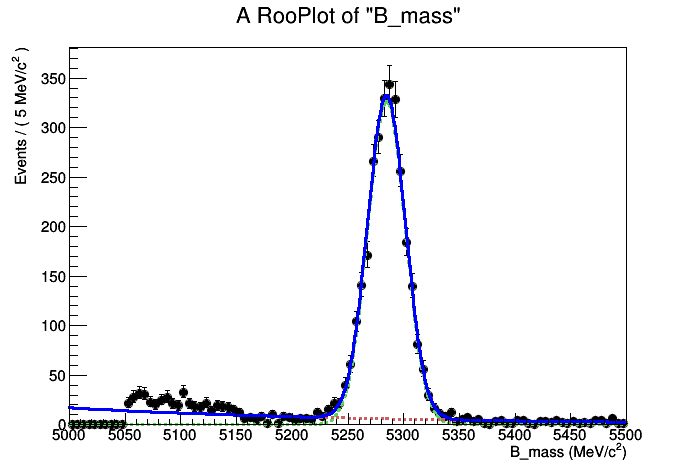

In [84]:
print("Yield: {} +/- {}").format(resultArray[0],resultArray[1])
print("")
print("Chi2: {}").format(resultArray[2])
canvas.Draw()

###Calculating the assymetry 

In [0]:
# B+ --> K+ K+ K-
# B- --> K- K- K+
# cut for it to be a B+
cut_Bplus = "(H1_Charge==1 & H2_Charge==1 & H3_Charge==-1) | (H1_Charge==1 & H2_Charge==-1 & H3_Charge==1) | (H1_Charge==-1 & H2_Charge==1 & H3_Charge==1)"

#cut for it to be a B-
cut_Bminus= "(H1_Charge==1 & H2_Charge==-1 & H3_Charge==-1) | (H1_Charge==-1 & H2_Charge==-1 & H3_Charge==1) | (H1_Charge==-1 & H2_Charge==1 & H3_Charge==-1)"


In [0]:
#Let's focus on the Bplus particle and calculate its yield
cut = "(!H1_isMuon & !H2_isMuon & !H3_isMuon & H1_ProbPi < 0.15 & H2_ProbPi < 0.15 & H3_ProbPi < 0.15 & H1_ProbK > 0.5 & H2_ProbK > 0.5 & H3_ProbK > 0.5 & B_VertexChi2 < 6)"
cut_string = "{} & {}".format(cut_Bplus,cut)
tree_bplus = tree.CopyTree(cut_string)

In [0]:
#following exactly what we did for B_mass
fromTree = tree_bplus
variable = B_mass
variableName = "B_mass"
variableUnit = "MeV/c^{2}"
variableParams = [5000,5500]

GaussParams = [5285, 5100, 5400, 10, 5, 15]
ExpoParams = [0.1,-1,1]
cbWidthParams = [15,10,20]
#This array is just to hold the results of our fit
resultArray = []

bplus_histo = ROOT.TH1F("bplus_histo","histogram for fitting",200,5000,6000)
tree_bplus.Draw(variable+">>bplus_histo(200,5000,6000)")
bplus_histo = ROOT.gDirectory.Get("bplus_histo")
bplus_histo.SetTitle("Fitted Data")
bplus_histo.GetXaxis().SetTitle("Mass MeV/c^{2}")
bplus_histo.GetYaxis().SetTitle("Events")
bplus_histo.Draw()

fitData(resultArray,bplus_histo,fromTree,variable,variableName,variableUnit,variableParams,GaussParams,ExpoParams,cbWidthParams,Expo=True,CB=False)
canvas.Update()
canvas.Draw()

B+
Yield: 1784.85754288 +/- 60.5300612519

Chi2: 1.07566567016


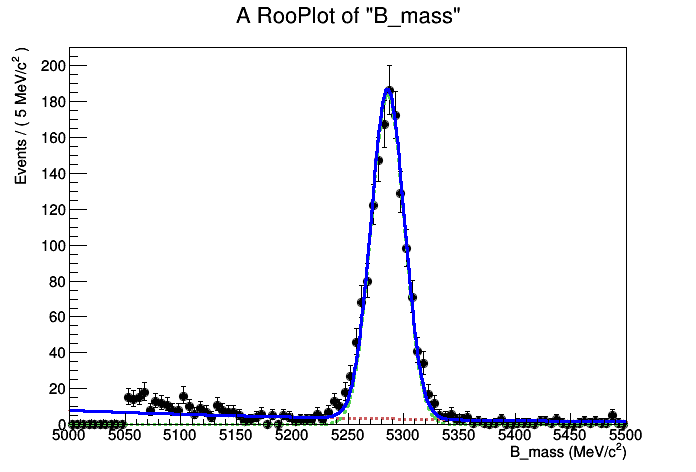

In [110]:
print("B+")
print("Yield: {} +/- {}").format(resultArray[0],resultArray[1])
print("")
print("Chi2: {}").format(resultArray[2])
canvas.Draw()

In [0]:
#And now for the B minus
#Let's focus on the Bplus particle and calculate its yield
cut = "(!H1_isMuon & !H2_isMuon & !H3_isMuon & H1_ProbPi < 0.15 & H2_ProbPi < 0.15 & H3_ProbPi < 0.15 & H1_ProbK > 0.5 & H2_ProbK > 0.5 & H3_ProbK > 0.5 & B_VertexChi2 < 6)"
cut_string = "{} & {}".format(cut,cut_Bminus)
tree_bminus = tree.CopyTree(cut_string)

In [0]:
#Fit for Bminus
fromTree = tree_bminus
variable = B_mass
variableName = "B_mass"
variableUnit = "MeV/c^{2}"
variableParams = [5000,5500]

GaussParams = [5285, 5100, 5400, 15, 10, 20]
ExpoParams = [0.1,-1,1]
cbWidthParams = [15,10,20]
#This array is just to hold the results of our fit
resultArray = []

bminus_histo = ROOT.TH1F("bminus_histo","histogram for fitting",200,5000,6000)
tree_bminus.Draw(variable+">>bminus_histo(200,5000,6000)")
bminus_histo = ROOT.gDirectory.Get("bminus_histo")
bminus_histo.SetTitle("Fitted Data")
bminus_histo.GetXaxis().SetTitle("Mass MeV/c^{2}")
bminus_histo.GetYaxis().SetTitle("Events")
bminus_histo.Draw()

fitData(resultArray,bminus_histo,fromTree,variable,variableName,variableUnit,variableParams,GaussParams,ExpoParams,cbWidthParams,Expo=True,CB=False)
canvas.Update()
canvas.Draw()

B-
Yield: 1770.97374402 +/- 60.3625600513

Chi2: 1.11126540468


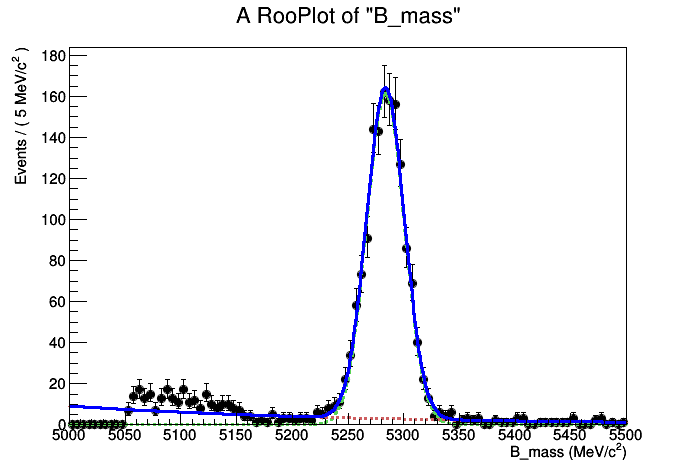

In [108]:
print("B-")
print("Yield: {} +/- {}").format(resultArray[0],resultArray[1])
print("")
print("Chi2: {}").format(resultArray[2])
canvas.Draw()

In [120]:
#Manually entering all the yields and errors, we can calculate the assymetry
N_bplus     = 1784.85754288   

N_bminus    = 1770.97374402 

A = (N_bplus - N_bminus) / (N_bplus + N_bminus)
error = math.sqrt( (1 - A**2) / (N_bplus - N_bminus) )

print("Assymetry: {} +/- {}").format(A,error)

Assymetry: 0.00390451563637 +/- 0.268375293803


With this we can see that there is some assymetry. We've shown for one particle that assymetry exists, so this might be true for many other particles. Thus, the reason we aren't all annihilated yet. 